In [1]:
from fatiando.gravmag import normal_gravity
from fatiando.vis import mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from icgem import load_icgem_gdf

In [3]:
dados = load_icgem_gdf('eigen-6c4-grav-ell2.gdf')

In [4]:
dados

{'area': [-14.681837, -14.671837, 319.088837, 324.153837],
 'gravity_ell': array([ 976813.89841636,  976814.60924932,  976815.3324105 , ...,
         976805.34993053,  976805.39971343,  976805.44432356]),
 'height': array([ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.]),
 'latitude': array([-14.6818, -14.6818, -14.6818, ..., -14.6718, -14.6718, -14.6718]),
 'longitude': array([ 319.0888,  319.0938,  319.0988, ...,  324.1438,  324.1488,
         324.1538]),
 'metadata': 'generating_institute     gfz-potsdam\n     generating_date     2015/10/16\n        product_type     gravity_field\n                body     earth\n           modelname     eigen-6c4\n     max_used_degree          2190\n         tide_system     tide_free\n          functional     gravity_ell  (centrifugal term included)\n                unit     mgal\n          refsysname     WGS84\n            gmrefpot      3.98600441800E+14 m**3/s**2\n        radiusrefpot     6378137.000 m\n          flatrefpot      3.35281066474

In [5]:
lon, lat, height, gravity = dados['longitude'], dados['latitude'], dados['height'], dados['gravity_ell']

In [6]:
height.shape

(3042,)

In [7]:
dados = load_icgem_gdf('eigen-6c4-topo2.gdf')

In [8]:
dados

{'area': [-14.681837, -14.671837, 319.088837, 324.153837],
 'latitude': array([-14.681837, -14.681837, -14.681837, ..., -14.671837, -14.671837,
        -14.671837]),
 'longitude': array([ 319.088837,  319.093837,  319.098837, ...,  324.143837,
         324.148837,  324.153837]),
 'metadata': 'generating_institute     gfz-potsdam\n     generating_date     2015/10/16\n        product_type     topography\n                body     earth\n           modelname     etopo1_bin_int\n          functional     topography_grd (grid)=>bi-linear interpolation\n                unit     meter\n          refsysname     WGS84\n        radiusrefsys     6378137.000 m\n          flatrefsys      3.352810664747480E-03   (1/298.25722356300)\n       long_lat_unit     degree\n      latlimit_north      -14.671837000000    \n      latlimit_south      -14.681837000000    \n      longlimit_west       319.08883700000    \n      longlimit_east       324.15383700000    \n            gridstep      0.50000000000000E-02\n

In [9]:
topo = dados['topography_grd']

In [10]:
# First, lets calculate the gravity disturbance (e.g., the free-air anomaly)
# We'll do this using the closed form of the normal gravity for the WGS84
# ellipsoid
gamma = normal_gravity.gamma_closed_form(lat, height)
disturbance = gravity - gamma

In [11]:
# Now we can remove the effect of the Bouguer plate to obtain the Bouguer
# anomaly. We'll use the standard densities of 2.67 g.cm^-3 for crust and 1.04
# g.cm^-3 for water.
bouguer = disturbance - normal_gravity.bouguer_plate(topo)

In [12]:
topo_positive = topo[topo >= 0]
topo_negative = topo[topo < 0]

In [13]:
jacobian = np.zeros([len(bouguer),2])
jacobian[topo < 0, 0] = topo_negative
jacobian[topo >= 0, 1] = topo_positive

In [14]:
y = bouguer

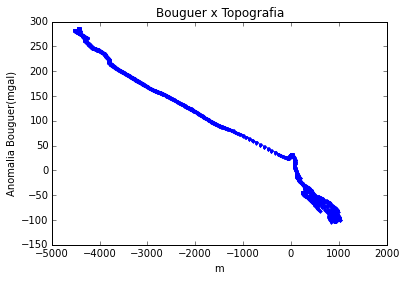

In [15]:
plt.figure()
plt.plot(topo,bouguer,'.')
plt.title('Bouguer x Topografia')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')

### Cálculo do parâmetro por mínimos quadrados

In [97]:
a_est = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),jacobian)),jacobian.transpose()),y)
print('a estimado=',a_est)

('a estimado=', array([-0.06052397, -0.09904182]))


### Cálculo do parâmetro por mínimos quadrados reponderado

In [16]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [17]:
result #primeiro componente corresponde ao locais com height<0 e o outro a height>0

[array([-0.06052397, -0.09904182]),
 array([-0.06039787, -0.09902636]),
 array([-0.06034798, -0.09899385]),
 array([-0.06032736, -0.0989821 ]),
 array([-0.06029652, -0.09895742]),
 array([-0.06027748, -0.09894607]),
 array([-0.06025869, -0.09892771]),
 array([-0.06024624, -0.09890362]),
 array([-0.06024098, -0.09887692]),
 array([-0.06023305, -0.09884892])]

In [19]:
y_calc = np.zeros([len(bouguer)])
y_calc[topo < 0] = result[9][0]*topo_negative
y_calc[topo >= 0] = result[9][1]*topo_positive

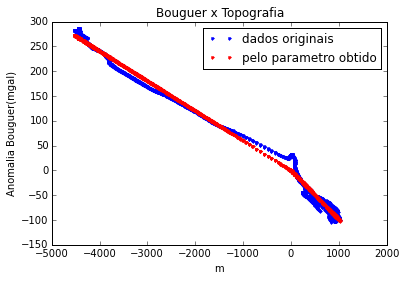

In [20]:
plt.figure()
plt.plot(topo,bouguer,'.',label='dados originais')
plt.plot(topo,y_calc,'.r',label='pelo parametro obtido')
plt.title('Bouguer x Topografia')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')
plt.legend()

In [21]:
h_neg = topo_negative*(2.67-1.04)/2.67 #calculo de h_eq
h_pos = topo_positive

In [22]:
topo_positive.shape

(1113,)

In [23]:
topo_negative.shape

(1929,)

In [24]:
jacobian = np.zeros([len(bouguer),2])
jacobian[topo < 0, 0] = h_neg 
jacobian[topo >= 0, 1] = h_pos

In [25]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [26]:
result

[array([-0.0991405 , -0.09904182]),
 array([-0.09893394, -0.09902636]),
 array([-0.09885221, -0.09899385]),
 array([-0.09881844, -0.0989821 ]),
 array([-0.09876792, -0.09895742]),
 array([-0.09873674, -0.09894607]),
 array([-0.09870596, -0.09892771]),
 array([-0.09868556, -0.09890362]),
 array([-0.09867694, -0.09887692]),
 array([-0.09866396, -0.09884892])]

In [27]:
y_calc = np.zeros([len(bouguer)])
y_calc[topo < 0] = result[9][0]*h_neg
y_calc[topo >= 0] = result[9][1]*h_pos

In [28]:
h_pos.shape

(1113,)

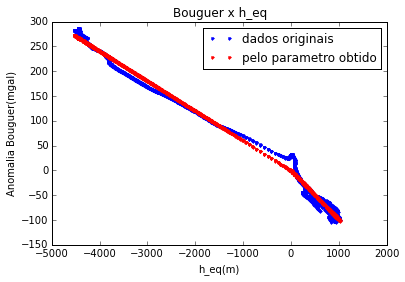

In [29]:
plt.figure()
plt.plot(topo,bouguer,'.',label='dados originais')
plt.plot(topo,y_calc,'.r',label='pelo parametro obtido')
plt.title('Bouguer x h_eq')
plt.xlabel('h_eq(m)')
plt.ylabel('Anomalia Bouguer(mgal)')
plt.legend()


### Desconsiderando profundidades > 3500 m

In [30]:
topo_cut = topo[topo>-3500.0]
topo_positive = topo_cut[topo_cut >= 0]
topo_negative = topo_cut[topo_cut < 0]

In [32]:
bouguer_cut = bouguer[topo > -3500]

In [33]:
jacobian = np.zeros([len(bouguer_cut),2])
jacobian[topo_cut < 0, 0] = topo_negative
jacobian[topo_cut >= 0, 1] = topo_positive

In [34]:
y = bouguer_cut

In [35]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [36]:
result

[array([-0.05735209, -0.09904182]),
 array([-0.05728807, -0.09902636]),
 array([-0.05722462, -0.09899385]),
 array([-0.05716917, -0.0989821 ]),
 array([-0.05712175, -0.09895742]),
 array([-0.05707519, -0.09894607]),
 array([-0.05702945, -0.09892771]),
 array([-0.05700446, -0.09890362]),
 array([-0.05696674, -0.09887692]),
 array([-0.05694629, -0.09884892])]

In [37]:
y_calc = np.zeros([len(bouguer_cut)])
y_calc[topo_cut < 0] = result[9][0]*topo_negative
y_calc[topo_cut >= 0] = result[9][1]*topo_positive

### Height > -3500

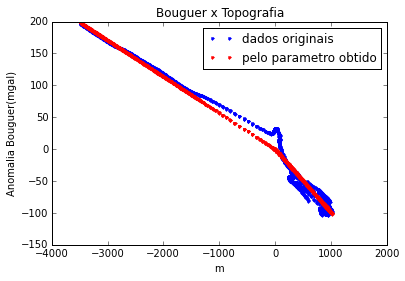

In [38]:
plt.figure()
plt.plot(topo_cut,bouguer_cut,'.',label='dados originais')
plt.plot(topo_cut,y_calc,'.r',label='pelo parametro obtido')
plt.title('Bouguer x Topografia')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')
plt.legend()


## Tentando retirar anomalias próximas ao zero (height<-200) e height > -3500.

In [144]:
cut = -1000.
topo_cut = topo[(topo > -3500) & (topo < cut) | (topo >= 0.)]
topo_positive = topo_cut[topo_cut >= 0]
topo_negative = topo_cut[(topo_cut < cut)]

In [145]:
topo_cut.shape

(1625,)

In [146]:
topo_negative.shape

(512,)

In [147]:
topo_positive.shape

(1113,)

In [203]:
# não mais necessário
h_neg = topo_negative*(2.67-1.04)/2.67 #calculo de h_eq
h_pos = topo_positive

In [148]:
bouguer_cut = bouguer[(topo > -3500) & (topo < cut) | (topo>=0.)]

In [149]:
jacobian = np.zeros([len(bouguer_cut),2])
jacobian[topo_cut < cut, 0] = topo_negative
jacobian[topo_cut >= 0, 1] = topo_positive

In [150]:
y = bouguer_cut

In [207]:
len(y)

554

In [151]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [152]:
x = np.arange(-3500.,1001,1)
y_calc = np.zeros([len(x)])

y_calc[0:3500] = result[9][0]*np.arange(-3500.,0,1)
y_calc[3500:4501] = result[9][1]*np.arange(0.,1001,1)

In [153]:
result

[array([-0.05724661, -0.09904182]),
 array([-0.05718609, -0.09902636]),
 array([-0.05712875, -0.09899385]),
 array([-0.05708005, -0.0989821 ]),
 array([-0.0570242 , -0.09895742]),
 array([-0.05698765, -0.09894607]),
 array([-0.05695824, -0.09892771]),
 array([-0.05694209, -0.09890362]),
 array([-0.05690389, -0.09887692]),
 array([-0.05687625, -0.09884892])]

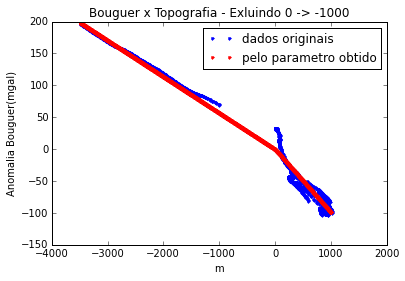

In [155]:
plt.figure()
plt.plot(topo_cut,bouguer_cut,'.',label='dados originais')
plt.plot(x,y_calc,'.r',label='pelo parametro obtido')
plt.title('Bouguer x Topografia - Exluindo 0 -> -1000')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')
plt.legend()
